# Imaging Analysis
I have a bunch of Gemini/NIRI data with companion confirmations. I need to measure the $\Delta m$, $\rho$, and $\theta$ values for each. I will use the [sep](http://sep.readthedocs.org/en/v0.5.x/) code...

In [1]:
from __future__ import print_function, division

import numpy as np
from astropy.io import fits
import sep
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from matplotlib.cm import viridis
from matplotlib.patches import Ellipse

sns.set_context('notebook', font_scale=1.5)
sns.set_style('whitegrid')

%matplotlib inline


/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Read in the data
filename = '/home/kgullikson/School/Research/NIRI_data/20151016/HIP100907.fits'
hdulist = fits.open(filename)
data = hdulist[1].data
bs_data = data.byteswap().newbyteorder()
#err = hdulist[2].data
gain = hdulist[1].header['GAIN']
hdulist.close()

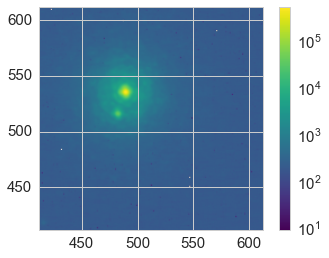

In [3]:
# Plot near the middle
nx, ny = data.shape
width = 100
plt.imshow(data, norm=LogNorm(vmin=10), cmap=viridis)
plt.xlim([nx/2-width, nx/2+width])
plt.ylim([ny/2-width, ny/2+width])
plt.colorbar()

In [4]:
# Get the spatially variable background
bkg = sep.Background(bs_data)

In [5]:
# Subtract the background from the data
bkg_subtraced_data = bs_data - bkg

In [6]:
# Extract the objects
thresh = 10.0 * bkg.globalrms
#objects = sep.extract(bkg_subtraced_data, thresh, minarea=10)
kernel = np.array([[1., 2., 3., 2., 1.],
                   [2., 3., 5., 3., 2.],
                   [3., 5., 8., 5., 3.],
                   [2., 3., 5., 3., 2.],
                   [1., 2., 3., 2., 1.]])
objects = sep.extract(bkg_subtraced_data, thresh, filter_kernel=kernel)

# objects is a numpy structured array:
len(objects)  # number of objects

2

In [7]:
# get the center and ellipse components
x, y = objects['x'], objects['y']
a, b = objects['a'], objects['b']
theta = objects['theta']
print(x, y)
print(a, b)
print(theta)

[ 482.11276683  488.88105089] [ 516.29203098  535.37289173]
[ 7.950562    9.06559277] [ 7.53073835  7.58896685]
[-1.0564909  -0.32501081]


In [8]:
# Get the kron radius (What is that???)
kronrad, krflag = sep.kron_radius(bkg_subtraced_data, x, y, a, b, theta, 6.0)
print(kronrad)
print(krflag)

[ 2.70313162  1.05778174]
[0 0]


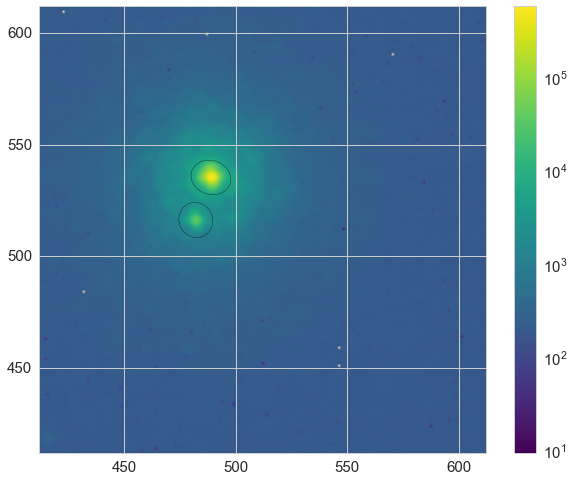

In [9]:
# Plot the ellipses on top of the data
nx, ny = data.shape
width = 100
fig, ax = plt.subplots(1, 1, figsize=(10,8))
im = ax.imshow(bs_data, norm=LogNorm(vmin=10), cmap=viridis)
ax.set_xlim([nx/2-width, nx/2+width])
ax.set_ylim([ny/2-width, ny/2+width])
plt.colorbar(im)

# Plot the ellipse:
for xi, yi, ai, bi, theta_i, kron in zip(x, y, a, b, theta, kronrad):
    #el = Ellipse(xy=np.array((xi, yi)), width=2*ai*kron, height=2*bi*kron, angle=theta_i*180/np.pi)
    el = Ellipse(xy=np.array((xi, yi)), width=2*ai, height=2*bi, angle=theta_i*180/np.pi)
    ax.add_artist(el)
    #el.set_alpha(0.5)
    el.set_edgecolor('black')
    el.set_facecolor('none')


In [10]:
# Sum the aperture
flux, fluxerr, flag = sep.sum_ellipse(bkg_subtraced_data, x, y, a, b, theta, 1.0,
                                      subpix=0, err=bkg.rms(), gain=1)
print(flux)
print(fluxerr)

[  1078625.67223805  13604500.04669645]
[ 1143.47040186  3727.01437044]


In [11]:
fl = np.random.normal(loc=flux, scale=fluxerr, size=(100000,2))
delta_m = 2.5*np.log10(fl[:, 0] / fl[:, 1])
l, m, h = np.percentile(delta_m, [16, 50, 84])
print('Delta K = {:.4f} +{:.5f} / -{:.5f}'.format(m, h-m, m-l))

Delta K = -2.7520 +0.00119 / -0.00119


That is pretty close to the expected value for this star, given the spectral type of the primary (A3V) and the companion temperature ($\sim 5200$ K). Note that I had to *not* use the kron radius that I calculated, and used gain = 1 instead of the header value of 246 to get reasonable errors...

# PSF Photometry
Now, see what answer I get with PSF photometry using the photutils package. I might need to use that since some of the companions are very close and blended with the primary star...

In [12]:
import photutils
from astropy.modeling import models, fitting

In [119]:
# Create a 2D moffat function

@models.custom_model
def Moffat2D(x, y, amplitude=1.0, x_0=512.0, y_0=512.0, x_gamma=6.0, y_gamma=6.0,
             alpha=1.0):
    """Two dimensional Moffat function with different scale parameters for both axes"""
    rr_gg = (x - x_0) ** 2 / x_gamma**2 + (y - y_0) ** 2 / y_gamma ** 2
    return amplitude * (1 + rr_gg) ** (-alpha)


@models.custom_model
def EllipticalMoffat2D(x, y, amplitude=1.0, x_0=512.0, y_0=512.0, 
                       x_gamma=6.0, y_gamma=6.0, theta=0.0,
                       alpha=1.0):
    """Two dimensional elliptical Moffat function with different scale parameters for both axes"""
    A = (np.cos(theta) / x_gamma)**2 + (np.sin(theta) / y_gamma)**2
    B = (np.sin(theta) / x_gamma)**2 + (np.cos(theta / y_gamma))**2
    C = 2 * np.sin(theta) * np.cos(theta) * (1/x_gamma**2 - 1/y_gamma**2)
    rr_gg = A*(x - x_0) ** 2 + B*(y - y_0) ** 2 + C*(x-x_0)*(y-y_0)
    return amplitude * (1 + rr_gg) ** (-alpha)



def Moffat2D_simple(x, y, amplitude=1.0, x_0=512.0, y_0=512.0, x_gamma=6.0, y_gamma=6.0,
             alpha=1.0):
    """Two dimensional Moffat function with different scale parameters for both axes"""
    rr_gg = (x - x_0) ** 2 / x_gamma**2 + (y - y_0) ** 2 / y_gamma ** 2
    return amplitude * (1 + rr_gg) ** (-alpha)

def EllipticalMoffat2D_simple(x, y, amplitude=1.0, x_0=512.0, y_0=512.0, 
                       x_gamma=6.0, y_gamma=6.0, theta=0.0,
                       alpha=1.0):
    """Two dimensional elliptical Moffat function with different scale parameters for both axes"""
    A = (np.cos(theta) / x_gamma)**2 + (np.sin(theta) / y_gamma)**2
    B = (np.sin(theta) / x_gamma)**2 + (np.cos(theta / y_gamma))**2
    C = 2 * np.sin(theta) * np.cos(theta) * (1/x_gamma**2 - 1/y_gamma**2)
    rr_gg = A*(x - x_0) ** 2 + B*(y - y_0) ** 2 + C*(x-x_0)*(y-y_0)
    return amplitude * (1 + rr_gg) ** (-alpha)

In [120]:
def fit_moffat_psf(data, x_mean=512, y_mean=512, x_fwhm=6, y_fwhm=6):
    """
    Fit a moffat function to the PSF. A moffat function is given by

    $I_r = I_0 [1+(r/\gamma)^2]^{-\alpha} $

    Where $I_0$ is the intensity at the center of the PSF, $\gamma$ is the
    half-width at half maximum in the absense of atmospheric scattering, and
    $\alpha$ is the atmospheric scattering coefficient.
    
    Parameters:
    ===========
    - data:      np.ndarray with shape(nx, ny)
                 The data to be fit.
                 
    - x_mean:    np.ndarray with shape (N_sources)
                 The initial guesses for the x-position of all of the sources to fit
                 
    - y_mean:    np.ndarray with shape (N_sources)
                 The initial guesses for the y-position of all of the sources to fit
                 
    - x_fwhm:    np.ndarray with shape (N_sources)
                 The initial guesses for the width of all of the sources in the x-direction
                 
    - y_fwhm:    np.ndarray with shape (N_sources)
                 The initial guesses for the width of all of the sources in the y-direction
    """
    # Make sure we have numpy arrays
    x_mean = np.atleast_1d(x_mean)
    y_mean = np.atleast_1d(y_mean)
    x_fwhm = np.atleast_1d(x_fwhm)
    y_fwhm = np.atleast_1d(y_fwhm)
    
    YY, XX = np.indices(data.shape)
    
    # Generate the model to fit
    p_init = models.Const2D(amplitude=0)
    for xi, yi, xwi, ywi in zip(x_mean, y_mean, x_fwhm, y_fwhm):
        p_init += Moffat2D(amplitude=data[np.round(yi).astype(int), np.round(xi).astype(int)],
                           x_0=xi, y_0=yi,
                           x_gamma=xwi, y_gamma=ywi,
                           alpha=1.0)
    
    # Tie the shape parameters together
    p_init.x_gamma_1.tied = lambda mod: mod.x_gamma_2
    p_init.y_gamma_1.tied = lambda mod: mod.y_gamma_2
    p_init.alpha_1.tied = lambda mod: mod.alpha_2

    # Fit the data
    fitter = fitting.LevMarLSQFitter()
    moffat = fitter(p_init, XX, YY, data, maxiter=1000)

    return moffat, fitter




In [121]:
moffat, fitter = fit_moffat_psf(bs_data, x_mean=x, y_mean=y, x_fwhm=a, y_fwhm=b)

In [122]:
# Put the parameters in a more reasonable structure
class Parameter(object):
    def __init__(self, name, val, err):
        self.name = name
        self.val = val
        self.err = err
    
    def __repr__(self):
        return '{}: {} +/_ {}'.format(self.name, self.val, self.err)
    
    def __str__(self):
        return '{}: {} +/_ {}'.format(self.name, self.val, self.err)
    
parlist = []
j = 0
cov = fitter.fit_info['param_cov']
for i, (name, value) in enumerate(zip(moffat.param_names, moffat.parameters)):
    if name not in ['x_gamma_1', 'y_gamma_1', 'alpha_1']:
        parlist.append(Parameter(name=name, val=value, err=np.sqrt(cov[j][j])))
        j += 1

for par in parlist:
    print(par)


amplitude_0: 213.673988898 +/_ 4.72296729642
amplitude_1: 43832.6648053 +/_ 1683.50232709
x_0_1: 482.155142395 +/_ 0.0962265732492
y_0_1: 516.015498927 +/_ 0.0976895828975
amplitude_2: 637523.75658 +/_ 3143.17378301
x_0_2: 489.051419111 +/_ 0.00661787227499
y_0_2: 535.251193885 +/_ 0.00671718429934
x_gamma_2: 3.1071899547 +/_ 0.0480564886364
y_gamma_2: 3.15409616725 +/_ 0.0488140677083
alpha_2: 2.34707828106 +/_ 0.0451904458429


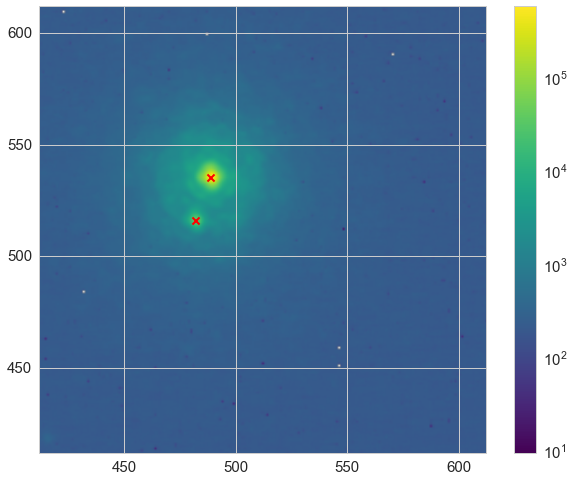

In [123]:
# Plot the fitted centroids
nx, ny = data.shape
width = 100
fig, ax = plt.subplots(1, 1, figsize=(10,8))
im = ax.imshow(bs_data, norm=LogNorm(vmin=10), cmap=viridis)
ax.set_xlim([nx/2-width, nx/2+width])
ax.set_ylim([ny/2-width, ny/2+width])
plt.colorbar(im)

x_centroid = np.array((moffat.x_0_1.value, moffat.x_0_2.value))
y_centroid = np.array((moffat.y_0_1.value, moffat.y_0_2.value))
#x_centroid = np.array((gauss.x_mean_1.value, gauss.x_mean_2.value))
#y_centroid = np.array((gauss.y_mean_1.value, gauss.y_mean_2.value))
#x_centroid = np.array((p_init.x_0_1.value, p_init.x_0_2.value))
#y_centroid = np.array((p_init.y_0_1.value, p_init.y_0_2.value))
ax.scatter(x_centroid, y_centroid, marker='x', s=50, c='red', linewidths=2)

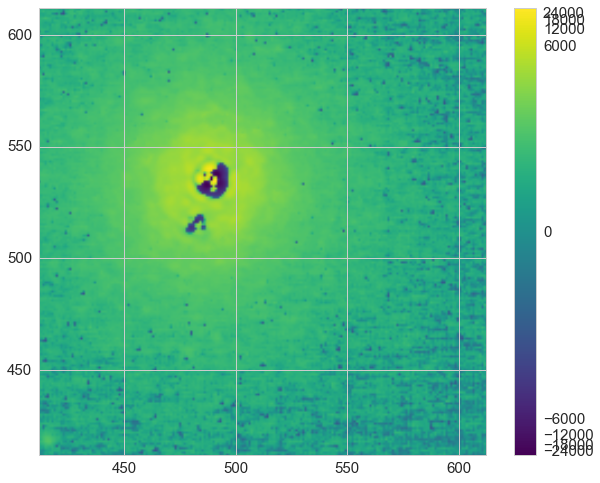

In [125]:
# Plot the residuals
nx, ny = data.shape

YY, XX = np.indices(bs_data.shape)
width = 100
fig, ax = plt.subplots(1, 1, figsize=(10,8))
im = ax.imshow(bs_data - moffat(XX, YY), cmap=viridis, norm=SymLogNorm(linthresh=10))
#im = ax.imshow(moffat(XX, YY), cmap=viridis, norm=SymLogNorm(linthresh=10))
ax.set_xlim([nx/2-width, nx/2+width])
ax.set_ylim([ny/2-width, ny/2+width])
plt.colorbar(im)

In [19]:
from scipy.integrate import dblquad

In [116]:
def calculate_integral(moffat_fcn, nstd=10):
    left_bound = max(moffat_fcn.x_0 - nstd*moffat_fcn.x_gamma, 0)
    right_bound = min(1024, moffat_fcn.x_0 + nstd*moffat_fcn.x_gamma)
    lower_bound = max(moffat_fcn.y_0 - nstd*moffat_fcn.y_gamma, 0)
    upper_bound = min(1024, moffat_fcn.y_0 + nstd*moffat_fcn.y_gamma)
    
    result = dblquad(moffat_fcn, a=left_bound, b=right_bound,
                     gfun=lambda x: lower_bound,
                     hfun=lambda y: upper_bound)
    return result


def integrate(moffat_fcn, nstd=10):
    """ Integrate both moffat functions independently
    """
    
    moffat1 = Moffat2D(amplitude=moffat_fcn.amplitude_1,
                       x_0=moffat_fcn.x_0_1,
                       y_0=moffat_fcn.y_0_1,
                       x_gamma=moffat_fcn.x_gamma_1,
                       y_gamma=moffat_fcn.y_gamma_1,
                       alpha=moffat_fcn.alpha_1)
    
    moffat2 = Moffat2D(amplitude=moffat_fcn.amplitude_2,
                       x_0=moffat_fcn.x_0_2,
                       y_0=moffat_fcn.y_0_2,
                       x_gamma=moffat_fcn.x_gamma_2,
                       y_gamma=moffat_fcn.y_gamma_2,
                       alpha=moffat_fcn.alpha_2)
    
    result1 = calculate_integral(moffat1, nstd=nstd)
    result2 = calculate_integral(moffat2, nstd=nstd)
    return result1, result2


def calculate_integral_simple(pars):
    amplitude, x0, y0, x_gamma, y_gamma, alpha, nstd = pars
    left_bound = max(x0 - nstd*x_gamma, 0)
    right_bound = min(1024, x0 + nstd*x_gamma)
    lower_bound = max(y0 - nstd*y_gamma, 0)
    upper_bound = min(1024, y0 + nstd*y_gamma)
    
    result = dblquad(Moffat2D_simple, a=left_bound, b=right_bound,
                     gfun=lambda x: lower_bound,
                     hfun=lambda y: upper_bound, args=(amplitude, x0, y0, x_gamma, y_gamma, alpha))
    return result


def make_moffat_iterable(amplitude, x0, y0, xgamma, ygamma, alpha, N=100, nstd=20):
    """
    Make a bunch of moffat functions that sample the uncertainties in the fitted parameters
    """
    amp = np.random.normal(loc=amplitude.val, scale=amplitude.err, size=N)
    x_0 = np.random.normal(loc=x0.val, scale=x0.err, size=N)
    y_0 = np.random.normal(loc=y0.val, scale=y0.err, size=N)
    x_gamma = np.random.normal(loc=xgamma.val, scale=xgamma.err, size=N)
    y_gamma = np.random.normal(loc=ygamma.val, scale=ygamma.err, size=N)
    alpha = np.random.normal(loc=alpha.val, scale=alpha.err, size=N)
    for i in range(N):
        #moffat = Moffat2D(amplitude=amp[i],
        #                  x_0=x_0[i], y_0=y_0[i],
        #                  x_gamma=x_gamma[i], y_gamma=y_gamma[i],
        #                  alpha=alpha[i])
        #yield moffat
        #yield moffat.amplitude.value, moffat.x_0.value, moffat.y_0.value, moffat.x_gamma.value, moffat.y_gamma.value, moffat.alpha.value, nstd
        yield amp[i], x_0[i], y_0[i], x_gamma[i], y_gamma[i], alpha[i], nstd

In [21]:
import multiprocessing

In [22]:
p = multiprocessing.Pool(processes=8)

In [109]:
# Make a parameter list
parlist = []
j = 0
for i, (name, value) in enumerate(zip(moffat.param_names, moffat.parameters)):
    if name not in ['x_gamma_1', 'y_gamma_1', 'alpha_1']:
        parlist.append(Parameter(name=name, val=value, err=np.sqrt(cov[j][j])))
        j += 1
        
# Assign the parameters to variables by name
for par in parlist:
    if par.name == 'amplitude_1':
        amplitude_1 = par
    elif par.name == 'amplitude_2':
        amplitude_2 = par
    if par.name == 'x_0_1':
        x0_1 = par
    elif par.name == 'x_0_2':
        x0_2 = par
    if par.name == 'y_0_1':
        y0_1 = par
    elif par.name == 'y_0_2':
        y0_2 = par
    elif 'x_gamma' in par.name:
        xgamma_1 = par
        xgamma_2 = par
    elif 'y_gamma' in par.name:
        ygamma_1 = par
        ygamma_2 = par
    elif 'alpha' in par.name:
        alpha_1 = par
        alpha_2 = par

In [29]:
I1 = make_moffat_iterable(amplitude_1, x0_1, y0_1, xgamma_1, ygamma_1, alpha_1, N=10000, nstd=50)
result_1 = p.map(calculate_integral_simple, I1)

I2 = make_moffat_iterable(amplitude_2, x0_2, y0_2, xgamma_2, ygamma_2, alpha_2, N=10000, nstd=50)
result_2 = p.map(calculate_integral_simple, I2)

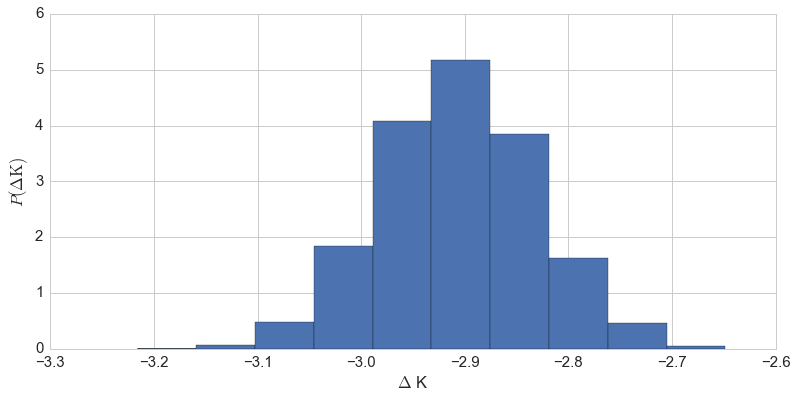

In [30]:
flux1 = np.array([r[0] for r in result_1])
flux2 = np.array([r[0] for r in result_2])
delta_m = 2.5 * np.log10(flux1/flux2)

fig, ax = plt.subplots(1, 1, figsize=(13,6))
ax.hist(delta_m, normed=True)
ax.set_xlabel(r'$\Delta$ K')
ax.set_ylabel(r'$P(\Delta \rm K)$')

# Sample with the full covariance matrix

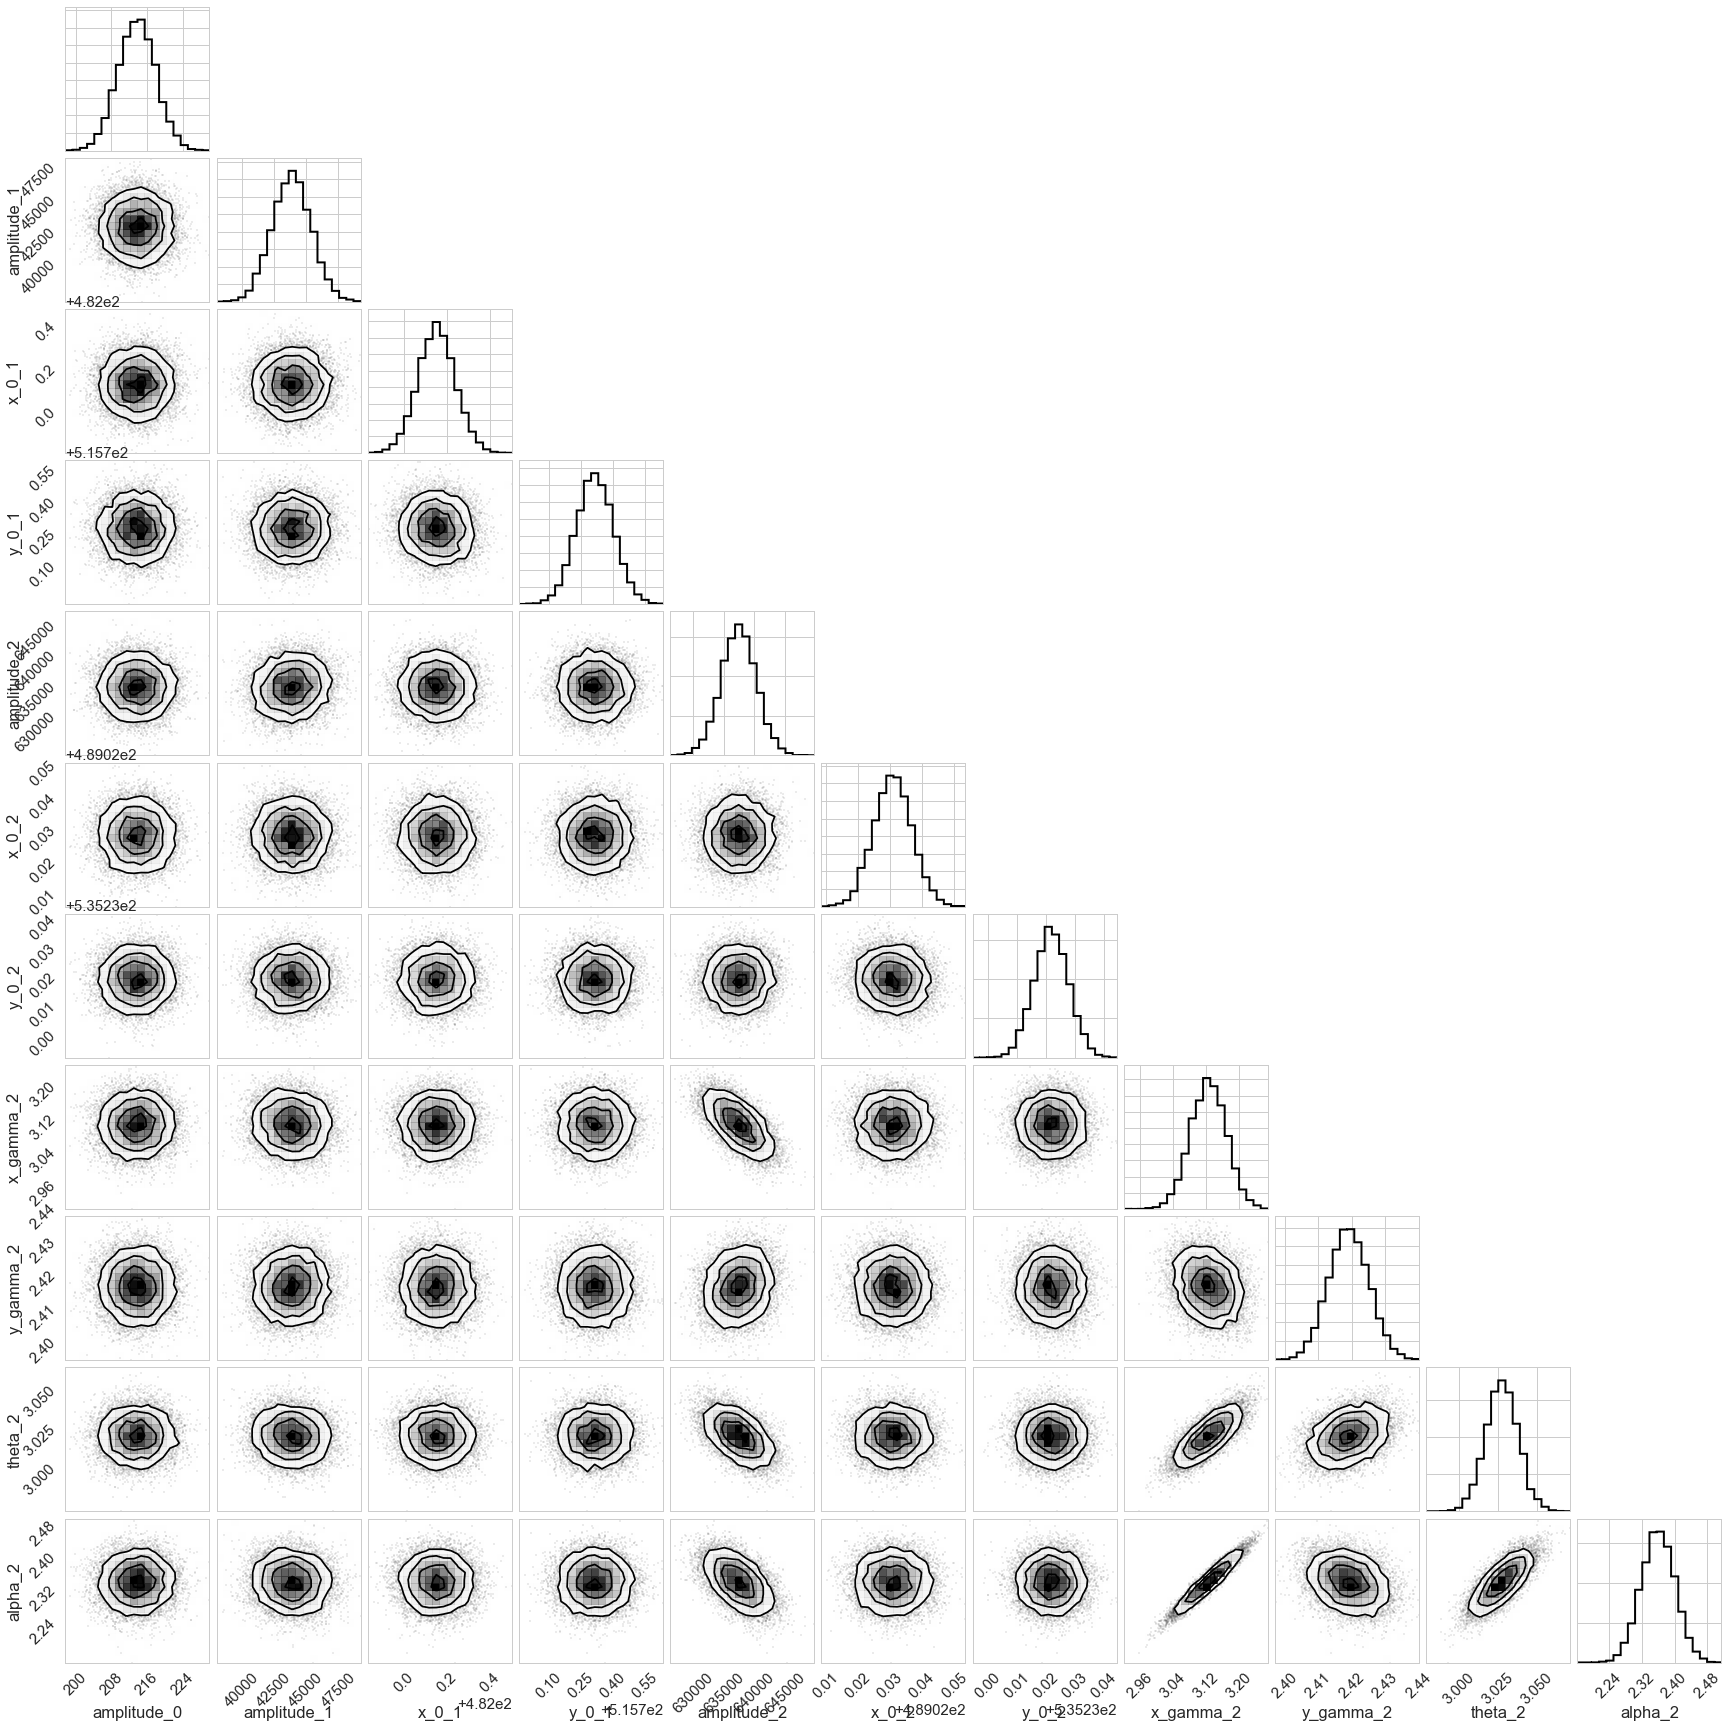

In [111]:

import pandas as pd
from scipy import stats
import corner

best_pars = []
names = []
for val, name in zip(moffat.parameters, moffat.param_names):
    if name not in ['x_gamma_1', 'y_gamma_1', 'alpha_1']:
        best_pars.append(val)
        names.append(name)

samples = stats.multivariate_normal.rvs(mean=best_pars, cov=cov, size=10000)
fig = corner.corner(samples, labels=names, hist_kwargs=dict(lw=2))

sample_df = pd.DataFrame(data=samples, columns=names)
sample_df['x_gamma_1'] = sample_df.x_gamma_2.copy()
sample_df['y_gamma_1'] = sample_df.y_gamma_2.copy()
sample_df['alpha_1'] = sample_df.alpha_2.copy()

In [114]:
def make_iterable(df, cols, nstd=20):
    N = df.shape[0]
    for i in range(N):
        row = list(df.loc[i, cols].values)
        row.append(nstd)
        yield row

I1 = make_iterable(sample_df, ['amplitude_1', 'x_0_1', 'y_0_1', 'x_gamma_1', 'y_gamma_1', 'alpha_1'], nstd=50)
result_1 = p.map(calculate_integral_simple, I1)

I2 = make_iterable(sample_df, ['amplitude_2', 'x_0_2', 'y_0_2', 'x_gamma_2', 'y_gamma_2', 'alpha_2'], nstd=50)
result_2 = p.map(calculate_integral_simple, I2)

Delta K_c = -2.91 +/- 0.04


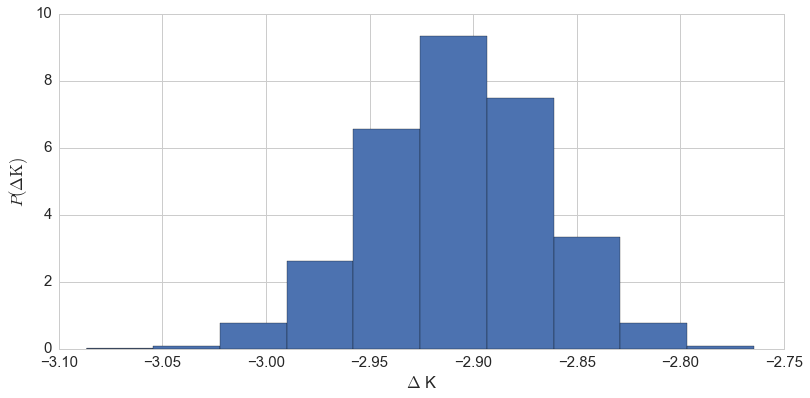

In [58]:
flux1 = np.array([r[0] for r in result_1])
flux2 = np.array([r[0] for r in result_2])
delta_m = 2.5 * np.log10(flux1/flux2)

fig, ax = plt.subplots(1, 1, figsize=(13,6))
ax.hist(delta_m, normed=True)
ax.set_xlabel(r'$\Delta$ K')
ax.set_ylabel(r'$P(\Delta \rm K)$')
print('Delta K_c = {:.2f} +/- {:.2f}'.format(np.mean(delta_m), np.std(delta_m)))

In [127]:
sample_df['flux1'] = flux1
sample_df['flux2'] = flux2
sample_df['delta_m'] = 2.5*np.log10(flux1/flux2)

In [66]:
from astropy import wcs
from astropy import units as u

header = fits.getheader(filename, 1)
w = wcs.WCS(header)

In [128]:
lat1, lon1 = w.all_pix2world(sample_df.x_0_1, sample_df.y_0_1, 0)
lat2, lon2 = w.all_pix2world(sample_df.x_0_2, sample_df.y_0_2, 0)

sample_df['rho'] = np.sqrt((lat1-lat2)**2 + (lon1-lon2)**2) * u.degree.to(u.arcsecond)
sample_df['theta'] = np.arctan2(lat2-lat1, lon2-lon1) * u.radian.to(u.degree)
sample_df[['rho', 'theta', 'delta_m']].describe()

,rho,theta,delta_m
count,10000.000000,10000.000000,10000.000000
mean,0.463028,-24.590155,-2.907157
std,0.001958,0.296730,0.041628
min,0.454981,-25.658706,-3.086521
25%,0.461717,-24.790461,-2.934621
50%,0.463031,-24.592278,-2.906667
75%,0.464360,-24.392366,-2.878621
max,0.471026,-23.359261,-2.764654


# Success!
This process works. I'll put everything together in a script to tabulate the stuff I care about.

In [131]:
import os
outfilename = 'data/Imaging/{}.csv'.format(os.path.basename(filename).split('.')[0])
sample_df.to_csv(outfilename, index=False)

'HIP100907.fits'